# Projet 5 Openclassrooms parcours Data Scientist
## Etudiante : Regaud Agnès


## 3ème notebook : simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.

In [1]:
package_list = ['pandas', 'numpy', 'matplotlib', 'scikit-learn']

In [2]:
!python3 -V

Python 3.9.13


In [3]:
txt = !python3 -m pip freeze
check = lambda i : any([(pack in i) for pack in package_list])
txt = [i for i in txt if check (i)]
txt

['matplotlib @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_757ijfo2tl/croots/recipe/matplotlib-suite_1660167932741/work',
 'matplotlib-inline @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9ddl71oqte/croots/recipe/matplotlib-inline_1662014471815/work',
 'numpy @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_10c245a1-1c81-453c-8b70-3e944787a8d9mo1xhesu/croots/recipe/numpy_and_numpy_base_1653915529188/work',
 'numpydoc @ file:///private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_753dae38-7ca3-4e28-bd02-7f92dc5dac540wd4kft3/croots/recipe/numpydoc_1657529877062/work',
 'pandas==1.4.4',
 'scikit-learn @ file:///opt/concourse/worker/volumes/live/cffa5efe-beec-4a37-5774-350794e43990/volume/scikit-learn_1642617139916/work',
 'scikit-learn-intelex==2021.20221004.121333']

# 1. Imports

In [4]:
#builtin
import os

#data
import pandas as pd
import numpy as np

#time
from datetime import datetime
from datetime import timedelta

#preprocessing
from sklearn.preprocessing import StandardScaler

from scipy import stats

#Clustering
from sklearn.cluster import KMeans
!pip install yellowbrick
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import SilhouetteVisualizer


from sklearn.metrics.cluster import adjusted_rand_score


#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data

In [5]:
path = "./data/Cleaned/"
filename = 'df_cleaned.csv'
df = pd.read_csv(path + filename)

In [6]:
df.head()

,customer_unique_id,customer_id,order_purchase_timestamp,order_id,payment_value_agreg,review_score
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,00e7ee1b050b8499577073aeb2a297a1,146.87,4.0
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:48:24,29150127e6685892b6eab3eec79f59c7,335.48,5.0
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-19 16:07:45,b2059ed67ce144a36e2aa97d2c9e9ad2,157.73,5.0
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 16:06:38,951670f92359f4fe4a63112aa7306eba,173.30,5.0
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 09:51:30,6b7d50bd145f6fc7f33cebabd7e49d0f,252.25,5.0


In [7]:
df.shape

(99440, 6)

In [8]:
df.isnull().sum()

customer_unique_id          0
customer_id                 0
order_purchase_timestamp    0
order_id                    0
payment_value_agreg         0
review_score                0
dtype: int64

In [9]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])


In [10]:
#Date de commande la plus récente :
date_fin_commandes = df['order_purchase_timestamp'].max()
date_fin_commandes

Timestamp('2018-10-17 17:30:18')

In [11]:
#Date de commande la plus vieille :
date_debut_commandes = df['order_purchase_timestamp'].min()
date_debut_commandes

Timestamp('2016-09-04 21:15:19')

In [12]:
#Durée des commande du dataset :


duree = df['order_purchase_timestamp'].max() - df['order_purchase_timestamp'].min()
duree

Timedelta('772 days 20:14:59')

In [13]:
#Rangement du dataset par ordre chronologique de commande :
df = df.sort_values(by = 'order_purchase_timestamp')
df.head()

,customer_unique_id,customer_id,order_purchase_timestamp,order_id,payment_value_agreg,review_score
84696,b7d76e111c89f7ebf14761390f0f7d17,08c5351a6aca1c1589a38f244edeee9d,2016-09-04 21:15:19,2e7a8482f6fb09756ca50c10d7bfc047,136.23,1.0
70560,4854e9b3feff728c13ee5fc7d1547e92,683c54fc24d40ee9f8a6fc179fd9856c,2016-09-05 00:15:34,e5fa5a7210941f7d56d0208e4e071d35,75.06,1.0
84844,009b0127b727ab0ba422f6d9604487c7,622e13439d6b5a0b486c435618b2679e,2016-09-13 15:24:19,809a282bbd5dbcabb6f2f724fca862ec,40.95,1.0
90293,0eb1ee9dba87f5b36b4613a65074337c,b106b360fe2ef8849fbbd056f777b4d5,2016-10-02 22:07:52,71303d7e93b399f5bcd537d124c0bcfa,109.34,1.0
38633,32ea3bdedab835c3aa6cb68ce66565ef,355077684019f7f60a031656bd7262b8,2016-10-03 09:44:50,3b697a20d9e427646d92567910af6d57,45.46,4.0


# 3. Modèle de segmentation des clients

In [14]:
#Calcul de la récence (la colonne de dates doit être au format date):
def recence(df) :
    #Calcul de la date de la dernière commande par client :
    df_recence = df.sort_values('order_purchase_timestamp', ascending=False).drop_duplicates(['customer_unique_id'])
    df_recence = df_recence[['customer_unique_id', 'order_purchase_timestamp']]
    df_recence.rename(columns={ 'order_purchase_timestamp': 'last_order_purchase_timestamp' }, inplace = True)
    #Calcul de la date la plus récente parmi toutes les commandes de df_recence:
    recent_date = df_recence['last_order_purchase_timestamp'].max()
    #Calcul de la récence :
    df_recence['Recency'] = df_recence['last_order_purchase_timestamp'].apply(lambda x: (recent_date - x).days)
    df_recence = df_recence[['customer_unique_id', 'Recency']]
    return df_recence


In [15]:
#Calcul de la fréquence :
def frequence(df) :
    #Compte du nombre de dates de commande pour chaque client (c'est aussi le nombre de commandes par client)
    df_frequence = df.groupby(by=['customer_unique_id'],
                          as_index=False)['order_purchase_timestamp'].count()
    df_frequence.columns = ['customer_unique_id', 'Frequency']
    return df_frequence

In [16]:
#Calcul du montant par client :
def montant(df) :
    df_montant = df.groupby(by='customer_unique_id',
                        as_index=False)['payment_value_agreg'].sum()
    df_montant.columns = ['customer_unique_id', 'Monetary']
    return df_montant

In [17]:
#Tableau RFM avec rang du client sur 100 :
def tableau_rfm(df) :
    df_recence = recence(df)
    df_frequence = frequence(df)
    df_montant = montant(df)
    df_rf = pd.merge(df_recence, df_frequence, on='customer_unique_id')
    df_rfm = pd.merge(df_rf, df_montant, on='customer_unique_id')
    #Calcul du rang pour chaque résultat :
    df_rfm_rank = df_rfm.copy()
    df_rfm_rank['R_rank'] = df_rfm_rank['Recency'].rank(ascending=False)
    df_rfm_rank['F_rank'] = df_rfm_rank['Frequency'].rank(ascending=True)
    df_rfm_rank['M_rank'] = df_rfm_rank['Monetary'].rank(ascending=True)
     
    # normalizing the rank of the customers (pourcentages)
    df_rfm_rank['R_rank_norm'] = (df_rfm_rank['R_rank']/df_rfm_rank['R_rank'].max())*100
    df_rfm_rank['F_rank_norm'] = (df_rfm_rank['F_rank']/df_rfm_rank['F_rank'].max())*100
    df_rfm_rank['M_rank_norm'] = (df_rfm_rank['M_rank']/df_rfm_rank['M_rank'].max())*100
     
    df_rfm_rank = df_rfm_rank.drop(columns=['R_rank', 'F_rank', 'M_rank'])
     
    return df_rfm_rank

In [18]:
#Ajout de l'avis moyen par client au tableau RFM :
def tableau_rfm_review(df) :
    df_rfm_rank = tableau_rfm(df)
    
    df_review_agreg = df.groupby(by='customer_unique_id',
                        as_index=False)['review_score'].mean().round(0)
    df_review_agreg.columns = ['customer_unique_id', 'avis moyen du client']
    df_rfm_review = pd.merge(df_rfm_rank, df_review_agreg, on='customer_unique_id')
    return df_rfm_review



In [19]:
#Partition des clients après standardisation des données :
def scaling(df_rfm_review) :
    scaler = StandardScaler()
    df_rfm_review_scaled = scaler.fit_transform(df_rfm_review[['R_rank_norm', 'F_rank_norm', 'M_rank_norm', 'avis moyen du client']])
    df_rfm_review_scaled = pd.DataFrame(df_rfm_review_scaled, columns= ['R_rank_norm', 'F_rank_norm', 'M_rank_norm', 'avis moyen du client'])
    return df_rfm_review_scaled


def partition(df_rfm_review_scaled, df_rfm_review) :
    kmeans_5 = KMeans(n_clusters=5, random_state=42)
    kmeans_5.fit(df_rfm_review_scaled)
    df_rfm_review['cluster_KM_5'] = kmeans_5.labels_
    df_rfm_review_clusters = df_rfm_review
    return df_rfm_review_clusters

def partition_predict(df_rfm_review_scaled, df_predict_rfm_review_scaled, df_predict_rfm_review) :
    kmeans_5 = KMeans(n_clusters=5, random_state=42)
    kmeans_5.fit(df_rfm_review_scaled)
    labels_predict = kmeans_5.predict(df_predict_rfm_review_scaled)
    df_predict_rfm_review['labels_predict'] = labels_predict
    df_predict_rfm_review_labels = df_predict_rfm_review
    return df_predict_rfm_review_labels


In [20]:
#Regroupement des étapes : tableau RFM, puis ajout de l'avis moyen, puis standardisation, puis k-means
def tableau_labels_predict(df_train, df_predict) :
    df_train_rank = tableau_rfm(df_train)
    df_train_review = tableau_rfm_review(df_train, df_train_rank)
    
    df_train_rank = tableau_rfm(df_train)
    df_predict_rfm_rank = tableau_rfm(df_predict)
    df_train_review = tableau_rfm_review(df_train, df_train_rank)
    df_predict_rfm_review = tableau_rfm_review(df_predict,df_predict_rfm_rank)
    df_train_review_scaled = scaling(df_train_review)
    df_predict_rfm_review_scaled = scaling(df_predict_rfm_review)
    df_predict_rfm_review_labels = partition_predict(df_train_review_scaled, df_predict_rfm_review_scaled, df_predict_rfm_review)
    return df_predict_rfm_review_labels

def tableau_labels_true(df, selection_customers) :
    df_rfm_rank = tableau_rfm(df)
    df_rfm_review = tableau_rfm_review(df, df_rfm_rank)
    df_rfm_review_scaled = scaling(df_rfm_review)
    df_rfm_review_clusters = partition(df_rfm_review_scaled, df_rfm_review)
    
    df_rfm_review_clusters_selection = df_rfm_review_clusters[df_rfm_review_clusters['customer_unique_id'].isin(selection_customers)]
    return df_rfm_review_clusters_selection
    
    
def tableau_rfm_review_scaled(df) :
    df_rfm_review = tableau_rfm_review(df)
    df_rfm_review_scaled = scaling(df_rfm_review)
    return df_rfm_review_scaled


# 4. Modèle de partition testé par période

## On découpe le dataset en 2 parts selon les dates de commande : on entraîne le modèle sur une période allant jusqu'à un temps donné qui varie de 1 semaine à T qui varie avant la fin de la période des commandes :

Text(0, 0.5, 'ARI_score')

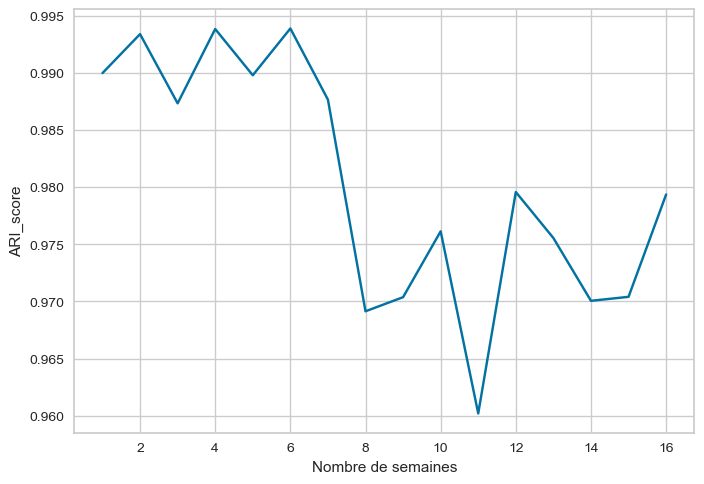

In [21]:
#Calcul de l'ARI sur quelques semaines (1 à 16)
df_rfm_review = tableau_rfm_review(df)
df_rfm_review_scaled = scaling(df_rfm_review)
kmeans_5_entier = KMeans(n_clusters=5, random_state=42)
kmeans_5_entier.fit(df_rfm_review_scaled)
labels_true = kmeans_5_entier.labels_
df_rfm_review['labels_true'] = kmeans_5_entier.labels_




ARI=[]
#n : nombre de semaines max
n = 16
for i in range(n) :
    duree_entrainement = 772 - (i+1)*7
    duree_test = (i+1)*7
    date_fin_entrainement = date_debut_commandes + timedelta(duree_entrainement)
    #DataFrame entier : df
    df_train = df[df['order_purchase_timestamp'] < date_fin_entrainement]
    df_predict = df[df['order_purchase_timestamp'] >= date_fin_entrainement]
    selection_customers = list(df_predict['customer_unique_id'])
    
    
    df_train_rfm_review_scaled = tableau_rfm_review_scaled(df_train)
    kmeans_5_partiel = KMeans(n_clusters=5, random_state=42)
    kmeans_5_partiel.fit(df_train_rfm_review_scaled)
    labels_predict = kmeans_5_partiel.predict(df_rfm_review_scaled)
    df_rfm_review['labels_predict'] = labels_predict

    
    ARI_score = adjusted_rand_score(labels_predict, labels_true)
    ARI.append(ARI_score)

plt.plot(range(1, n+1), ARI)
plt.xlabel("Nombre de semaines")
plt.ylabel("ARI_score")

Text(0, 0.5, 'ARI_score')

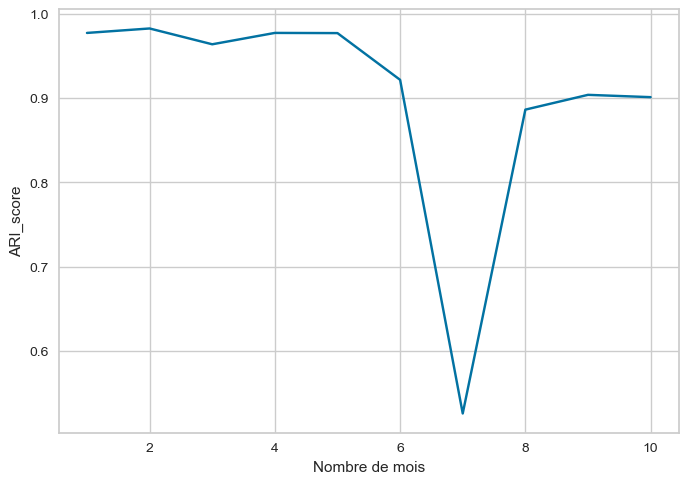

In [22]:
#Calcul de l'ARI sur plusieurs mois (1 à 10)
df_rfm_review = tableau_rfm_review(df)
df_rfm_review_scaled = scaling(df_rfm_review)
kmeans_5_entier = KMeans(n_clusters=5, random_state=42)
kmeans_5_entier.fit(df_rfm_review_scaled)
labels_true = kmeans_5_entier.labels_
df_rfm_review['labels_true'] = kmeans_5_entier.labels_




ARI=[]
#n : nombre de mois pour évaluer ARI-score

list_n = [1,2,3,4,5,6,7,8,9,10]

for i in list_n :
    duree_entrainement = 772 - i*30
    duree_test = i*30
    date_fin_entrainement = date_debut_commandes + timedelta(duree_entrainement)
    #DataFrame entier : df
    df_train = df[df['order_purchase_timestamp'] < date_fin_entrainement]
    df_predict = df[df['order_purchase_timestamp'] >= date_fin_entrainement]
    
    
    df_train_rfm_review_scaled = tableau_rfm_review_scaled(df_train)
    kmeans_5_partiel = KMeans(n_clusters=5, random_state=42)
    kmeans_5_partiel.fit(df_train_rfm_review_scaled)
    labels_predict = kmeans_5_partiel.predict(df_rfm_review_scaled)
    df_rfm_review['labels_predict'] = labels_predict

    
    ARI_score = adjusted_rand_score(labels_predict, labels_true)
    ARI.append(ARI_score)

plt.plot(list_n, ARI)
plt.xlabel("Nombre de mois")
plt.ylabel("ARI_score")

## On observe une chute à 7 mois qui peut être due à un changement de profil des commandes.
## Par exemple des promos sur le site.
## Vérifions qu'il ne s'agit pas d'un changement dans le nombre de commande au mois:

In [23]:
df_mars = df[('2018-03-01 00:00:00'<df['order_purchase_timestamp']) &  (df['order_purchase_timestamp']< '2018-04-01 00:00:00')]
df_mars.nunique()

customer_unique_id          7114
customer_id                 7210
order_purchase_timestamp    7150
order_id                    7210
payment_value_agreg         4696
review_score                   5
dtype: int64

In [24]:
df_avril = df[('2018-05-01 00:00:00'<df['order_purchase_timestamp']) &  (df['order_purchase_timestamp']< '2018-06-01 00:00:00')]
df_avril.nunique()

customer_unique_id          6814
customer_id                 6873
order_purchase_timestamp    6839
order_id                    6873
payment_value_agreg         4385
review_score                   5
dtype: int64

In [25]:
df[('2018-02-01 00:00:00'<df['order_purchase_timestamp']) &  (df['order_purchase_timestamp']< '2018-03-01 00:00:00')]

,customer_unique_id,customer_id,order_purchase_timestamp,order_id,payment_value_agreg,review_score
91993,056c58156ca6fd3d045cb72a9c9f89c0,8bbab60533a9749783e4c768cd5a12a7,2018-02-01 00:24:55,f17281018fc8b0ba9a8b08ac18360665,169.41,5.0
3720,d92087333b9c4afb7f6ec9d1258e2ea3,fbf5039b1d330e60055aa9f3969d3434,2018-02-01 00:33:25,26a353e90b1f35895b269ad0a5cdb114,221.88,5.0
48581,0818cf2b15a3b4ba451758083d57b9bf,4d8923819294bffca3edc507da304801,2018-02-01 00:35:39,8cd7be194601db331acee102c799242f,181.91,4.0
32751,9ab7c789eafeac4e56c370df1172c933,18b3ccdb39831edbfefc432e649d2585,2018-02-01 01:04:13,068306f3ae87b774e579eb36d5714ced,170.71,5.0
15293,553b07cb90e5a17d748dbcf842c00118,08b9cbfbf948ebc2dc43212aa3b5a2a2,2018-02-01 05:41:35,b0478e447df29ef9a7efd1eb63de629c,66.78,5.0
...,...,...,...,...,...,...
81573,9a74735754d42a0593bcf6356ab369e2,6e99733532423390e0d537024ac60812,2018-02-28 23:35:06,cecccaa359491439461332bbb0dad3d5,206.84,5.0
79202,032cfb33364e07ebcafb4b8a92d7eec4,010099752e4ca60e61c8a4a669ea9fe5,2018-02-28 23:42:55,0f02ea56e4c9e7d30adb19a0c3e07b02,86.02,4.0
65390,7018a5e068b8fd0912fed2d02952df23,b288fbdf739c5aaaa7bb5ebe0ed315e1,2018-02-28 23:48:09,3208081336d844f7752b1e939dd1bbac,92.83,5.0
55174,b316e256ce45161d3ab81f74834376e8,74d314a6a565ebd0d43988de8d69d49b,2018-02-28 23:57:18,bcda98e5747cea8a343a6af0e5da9f91,117.85,5.0


In [26]:
df_fevrier = df[('2018-02-01 00:00:00'<df['order_purchase_timestamp']) &  (df['order_purchase_timestamp']< '2018-03-01 00:00:00')]
df_fevrier.nunique()

customer_unique_id          6569
customer_id                 6728
order_purchase_timestamp    6679
order_id                    6728
payment_value_agreg         3804
review_score                   5
dtype: int64

In [27]:
df_fevrier_octobre = df[('2018-02-17 00:00:00'<df['order_purchase_timestamp']) &  (df['order_purchase_timestamp']< '2018-10-17 00:00:00')]
df_fevrier_octobre.nunique()

customer_unique_id          42204
customer_id                 43085
order_purchase_timestamp    42830
order_id                    43085
payment_value_agreg         17755
review_score                    5
dtype: int64

In [28]:
df_mars_octobre = df[('2018-03-17 00:00:00'<df['order_purchase_timestamp']) &  (df['order_purchase_timestamp']< '2018-10-17 00:00:00')]
df_mars_octobre.nunique()

customer_unique_id          35546
customer_id                 36177
order_purchase_timestamp    35975
order_id                    36177
payment_value_agreg         15623
review_score                    5
dtype: int64

In [29]:
df_avril_octobre = df[('2018-04-17 00:00:00'<df['order_purchase_timestamp']) &  (df['order_purchase_timestamp']< '2018-10-17 00:00:00')]
df_avril_octobre.nunique()

customer_unique_id          28706
customer_id                 29171
order_purchase_timestamp    29023
order_id                    29171
payment_value_agreg         13665
review_score                    5
dtype: int64

In [30]:
df_mai_octobre = df[('2018-05-17 00:00:00'<df['order_purchase_timestamp']) &  (df['order_purchase_timestamp']< '2018-10-17 00:00:00')]
df_mai_octobre.nunique()

customer_unique_id          20965
customer_id                 21273
order_purchase_timestamp    21162
order_id                    21273
payment_value_agreg         10835
review_score                    5
dtype: int64

## Il y a le même nombre de commande chaque mois : environ 7000 commandes